# Main Analysis Pipeline

In [4]:
import sys
sys.path.insert(0, '../modules')
from hits import CDCHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
from root_numpy import list_branches
%load_ext memory_profiler
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter
from cylinder import CDC

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Convenience Functions

In [5]:
# The most common are stored in these notebooks
%run visualizations.ipynb
%run data_tools.ipynb

Populating the interactive namespace from numpy and matplotlib


In [6]:
def set_additional_branches(sample, row_name=None, cell_id=None, relative_time=None):
    """
    Set the trigger time and cell ID branches
    """
    if row_name:
        sample.data[row_name] = sample.geom.get_layers(sample.data[sample.flat_name])
    if cell_id:
        sample.data[cell_id] = sample.geom.get_indexes(sample.data[sample.flat_name])
    if relative_time:
        sample.data[relative_time] = sample.data[sample.time_name] - sample.data[sample.trig_name]

## Access data

In [7]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    return [hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True) 
                for i in [0,-1,1]]

## Import the Signal Hits

In [8]:
def test_labelling(hit_sample, sig_name, momentum_name, value):
    current_labels = hit_sample.get_events()[sig_name]
    momentum_magnitude = np.sqrt(np.square(hit_sample.get_events()[momentum_name+'.fX']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fY']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fZ']))
    pid_values = hit_sample.get_events()[pid_name]
    new_labels = np.logical_and(momentum_magnitude > value, pid_values == 11)
    print("Number of signal now : {}".format(sum(current_labels)))
    print("Number of signal actual : {}".format(sum(new_labels)))
    print("Number mislabelled : {}".format(hit_sample.n_hits - sum(current_labels == new_labels)))

### Make cuts

In [9]:
def remove_coincidence(hit_samp, remove_hits=True):
    # Sort by local score name
    hit_samp.sort_hits(lcl_scr_name, ascending=False)
    all_hits_keep = hit_samp.get_measurement(hit_samp.hits_index_name, only_hits=True)
    # Make a mask   
    hit_samp.data[take_hit_name][all_hits_keep.astype(int)] = 1
    # Remove the hits
    if remove_hits:
        hit_samp.trim_hits(take_hit_name, values=1)
        hit_samp.sort_hits(hit_samp.flat_name)

## Define Our Samples

In [10]:
## Branches not needed
#drift_dist_name = prefix + "DriftDist"
#turn_id_name = prefix + "TurnID"
#pid_name = prefix + "Track.fPID"
#parent_track_id_name = prefix + "Track.fParentTrackID"
#all_momentum_names = [ prefix + "Track.f" + st_sp + "Momentum.f" + coor 
#                       for st_sp in ["Start", "Stop"] for coor in ["X", "Y", "Z"] ]
#all_pos_names = [ prefix + "Track.f" + st_sp + "PosGlobal.f" + coor 
#                       for st_sp in ["Start", "Stop"] for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
#hit_pos_names = [ prefix + "MCPos.f" + coor for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
#hit_mom_names = [ prefix + "MCMom.f" + coor for coor in ["X", "Y", "Z"] ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names

In [11]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"


## Branches to be filled
row_name = prefix +"Layers"
cell_id_name = prefix + "CellID"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"

empty_branches = [row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

In [12]:
these_branches = dict()
these_branches["CDC"] = [drift_name, 
                         track_id_name]
these_branches["CTH"] = None

In [16]:
file_root = "~/development/ICEDUST/track-finding-yandex/data/MC4p/"

back_samples = ["MC4p_background_sample_3bunch-train_1.root",
                "MC4p_background_sample_3bunch-train_2.root",
                "MC4p_background_sample_3bunch-train_3.root",
                "MC4p_background_sample_3bunch-train_4.root"]
sig_samples = [
    "oa_xx_xxx_09010000-0000_xerynzb6emaf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09110000-0000_2mdcao2ehzya_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09210000-0000_opfmr3awxs2m_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09310000-0000_v62e3u5ppkju_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09410000-0000_z2p5ysva45vx_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09510000-0000_3eox62hw5ygi_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09610000-0000_7ctgq54tptae_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09710000-0000_kah3t5htgouf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09810000-0000_a4tlhqvqnv4p_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09910000-0000_h6g347twij7d_user-TrkTree_000_500signal-label.root"]

sig_samples_700 = [
    "oa_xx_xxx_09010000-0000_bgd5wd5uhw2n_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09110000-0000_fiey62djp4gd_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09210000-0000_chqno3g2fxqs_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09310000-0000_paynw633hzqk_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09410000-0000_kd234xkjqddc_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09510000-0000_lpd33ym64roi_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09610000-0000_i37ocps322kr_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09710000-0000_t2l7rgghqqdq_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09810000-0000_mzoackf2gbk7_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09910000-0000_cbwuzp2l4inz_user-TrkTree_000_700signal-label.root"]

back_samples = [file_root + this_file for this_file in back_samples]
sig_samples = [file_root + this_file for this_file in sig_samples]

## Import the Data

In [2]:
%run data_tools.ipynb

In [1]:
train = data_import_sample(sig_samples[0], back_samples[0], 
                           these_cuts=["500","Trig","Track"],
                           branches=these_branches,
                           empty_branches=empty_branches)
set_additional_branches(train.cdc, 
                        row_name=row_name, 
                        cell_id=cell_id_name, 
                        relative_time=rel_time_name)

NameError: name 'data_import_sample' is not defined

## Prepare the data

In [19]:
bins_for_plots = 50
figsize(10,5)

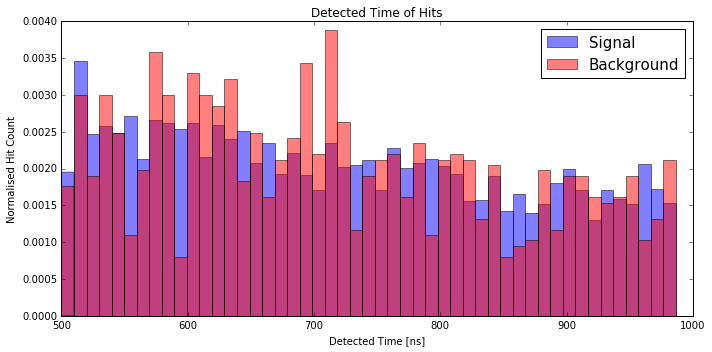

In [20]:
plot_feature( train.cth.get_signal_hits()[train.cth.time_name], 
              train.cth.get_background_hits()[train.cth.time_name], 
              xlabel="Detected Time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits", 
              nbins=bins_for_plots)
show()

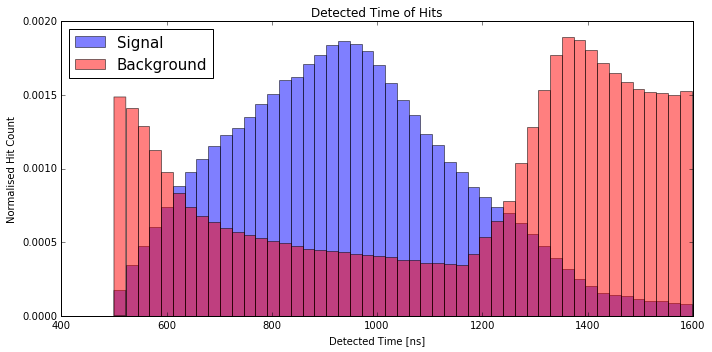

In [21]:
plot_feature( train.cdc.get_signal_hits()[train.cdc.time_name], 
              train.cdc.get_background_hits()[train.cdc.time_name], 
              xlabel="Detected Time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits", 
              nbins=bins_for_plots)
show()

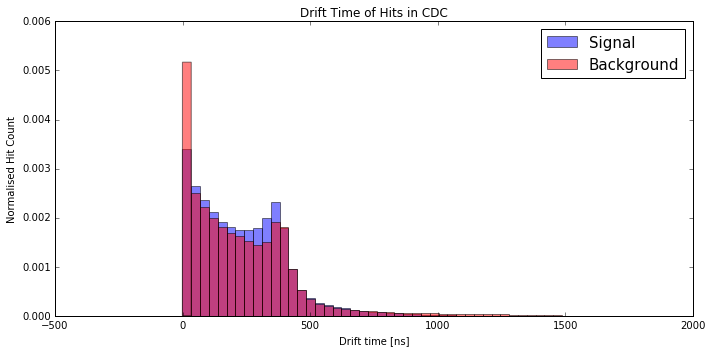

In [22]:
plot_feature( train.cdc.get_signal_hits()[drift_name], 
              train.cdc.get_background_hits()[drift_name], 
              xlabel="Drift time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Drift Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

In [23]:
event = 1000
print(np.unique(train.cth.get_events(event)["CTHHit.fTrigTime"]))
print(np.unique(train.cth.get_events(event)["CTHHit.fEventNumber"]))
print(np.unique(train.cdc.get_events(event)["CDCHit.fTrigTime"]))
print(np.unique(train.cdc.get_events(event)["CDCHit.fEventNumber"]))

[   0.          584.31887817]
[9046946]
[ 584.31887817]
[   1001 9046946]


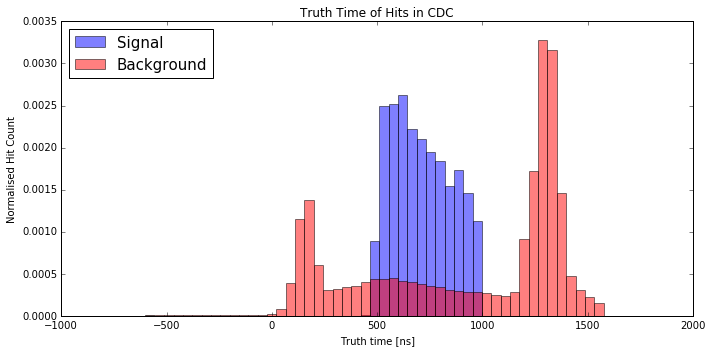

In [24]:
plot_feature( train.cdc.get_signal_hits()[train.cdc.time_name] -\
                  train.cdc.get_signal_hits()[drift_name],  
              train.cdc.get_background_hits()[train.cdc.time_name] -\
              train.cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC",  
              nbins=bins_for_plots)
show()

# Begin the Analysis

In [25]:
bins_for_plots = 50
figsize(6,4)

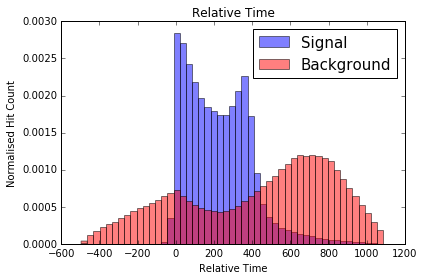

In [26]:
plot_feature( train.cdc.get_signal_hits()[rel_time_name],
              train.cdc.get_background_hits()[rel_time_name],
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

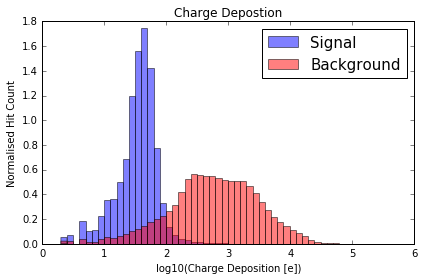

In [27]:
plot_feature( np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] + 1), 
              np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()

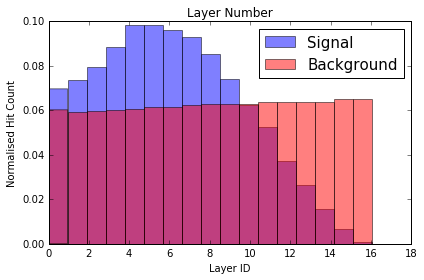

In [28]:
plot_feature( train.cdc.get_signal_hits()[row_name], 
              train.cdc.get_background_hits()[row_name], 
              xlabel="Layer ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Layer Number", 
              nbins=18)
show()

In [29]:
print(train.cdc.geom.n_points)

4482


In [30]:
sig_occ, back_occ, occ = train.cdc.get_occupancy()

Sig Occ: 84.85027969726883 , Back Occ : 623.3797301743995
All Occ: 695.2977953274103, 0.1551311457669367
NumHits: 738.9414281013492
MinMultiHit: 0.06276969820303747


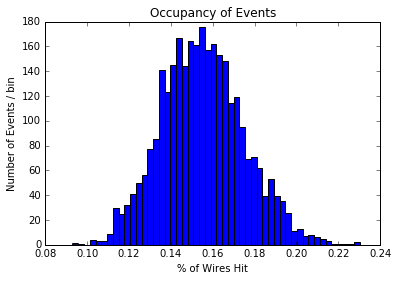

In [31]:
plt.title("Occupancy of Events")
plt.xlabel("% of Wires Hit")
plt.ylabel("Number of Events / bin")
plt.hist(np.array(occ)/4482., bins=50)
plt.show()

In [32]:
%run visualizations.ipynb
figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


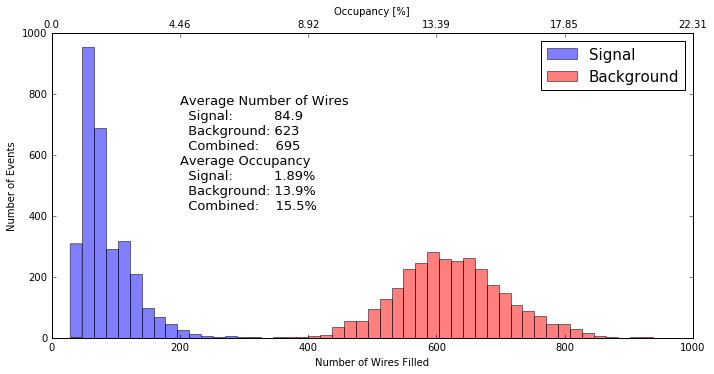

In [33]:
plot_occupancies(sig_occ, back_occ, occ,
                n_vols=4482, x_pos=0.2, y_pos=0.8)

## Local Classification : Deal with Coincidence

### Make training/testing splits

In [34]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [35]:
# Split up the data first
from sklearn.model_selection import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = list(range(train.cdc.n_events))
rest, sample_3     = train_test_split(rest, train_size=0.54, test_size=0.36, random_state=seed)
sample_1, sample_2 = train_test_split(rest, train_size=0.33, test_size=0.66, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2, sample_3 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

In [36]:
# Get a measurement to compare
#orig_edep = np.sort(train.cdc.get_events(evt_samp[0])[train.cdc.edep_name])
#new_edep = np.sort(train.cdc.get_events(new_samples[0])[train.cdc.edep_name])

In [37]:
# Remove unused events
all_events = evt_samp[0] + evt_samp[1] + evt_samp[2]
evt_name = []
for samp in evt_samp:
    evt_name.append(np.unique(train.cdc.get_events(samp)[train.cdc.key_name]))
good_events = np.unique(train.cdc.get_events(all_events)[train.cdc.key_name])
train.cdc.trim_hits(train.cdc.key_name, values=good_events)
# Relabel the hit samples
evt_samp = []
for new_samp in evt_name:
    this_hit = train.cdc.filter_hits(train.cdc.key_name, values=new_samp)[train.cdc.hits_index_name]
    this_evt = list(np.unique(train.cdc.hits_to_events[this_hit]))
    evt_samp.append(this_evt)
# Get the hit masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

### Classify Using Local Features

In [38]:
#from rep.metaml.factory import ClassifiersFactory
#from rep.estimators import SklearnClassifier, TMVAClassifier
#from rep.report.metrics import RocAuc
from collections import OrderedDict
from sklearn.ensemble import GradientBoostingClassifier
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [39]:
# Define Data
lcl_train_features = [train.cdc.edep_name, rel_time_name, row_name]

In [40]:
factory = OrderedDict()

# Define GBDT over neighbour-level features
local_gbdt = (GradientBoostingClassifier(n_estimators=100), lcl_train_features)
# Add the GBDT
factory['Local Features'] = local_gbdt

In [41]:
# Train the classifier
for classifier, features in factory.values():
    classifier.fit(DataFrame(train.cdc.data[features][hit_masks[0]]), 
                             train.cdc.data[train.cdc.hit_type_name][hit_masks[0]])

In [42]:
train.cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fTrack.fTrackID
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fCellID
CDCHit.fHough_Score
CDCHit.fLayers
CDCHit.fLocal_Score
CDCHit.fNeigh_Score
CDCHit.fRelative_Time
CDCHit.fTake_Hit
CDCHit.fTrack_Score
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [43]:
# Print these predictions
train.cdc.data[lcl_scr_name] = local_gbdt[0].predict_proba(DataFrame(train.cdc.data[lcl_train_features]))[:,1]
# Invalidate the training sample
train.cdc.data[lcl_scr_name][hit_masks[0]] = -1
# remove coincidence
remove_coincidence(train.cdc)
# Get the hit masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

0.98876284021


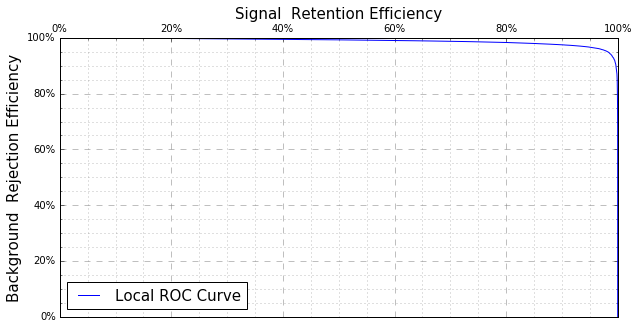

In [44]:
plot_roc_curve(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(lcl_scr_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               zoom=False, label="Local ROC Curve")
print(roc_auc_score(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(lcl_scr_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True)))
plt.show()

## Use Neighbour Level Features

In [45]:
# Define Data
neigh_train_features = [train.cdc.edep_name, 
                        train.cdc.edep_name + "_left",
                        train.cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        row_name]

In [46]:
# Define GBDT over neighbour-level features
neigh_gbdt = (GradientBoostingClassifier(n_estimators=100), neigh_train_features)
# Add the GBDT
factory['Neighbour and Local Features'] = neigh_gbdt

In [47]:
# Train the classifier
data = DataFrame(np.vstack(get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, evt_samp[1]) +\
                           get_measurment_and_neighbours(train.cdc, train.cdc.time_name, evt_samp[1]) +\
                          [train.cdc.data[row_name][hit_masks[1]]]).T, columns=neigh_train_features)
for classifier, features in factory.values():
    classifier.fit(data[features],train.cdc.data[train.cdc.hit_type_name][hit_masks[1]])
del data

In [48]:
# Print these predictions
train.cdc.data[ngh_scr_name] = neigh_gbdt[0].predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train.cdc, train.cdc.edep_name) +\
            get_measurment_and_neighbours(train.cdc, train.cdc.time_name) +\
            [train.cdc.data[row_name]]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
train.cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

0.997649145825


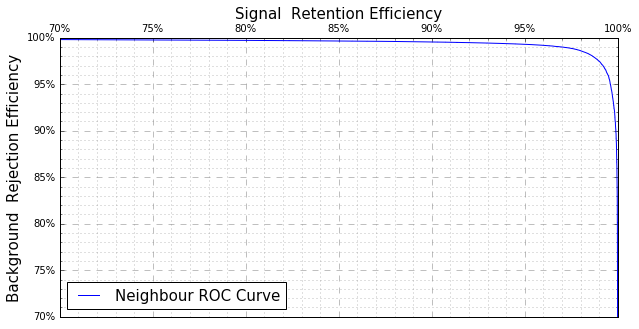

In [49]:
plot_roc_curve(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
               train.cdc.data[ngh_scr_name][hit_masks[2]], 
               zoom=True, label="Neighbour ROC Curve")
print(roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
               train.cdc.data[ngh_scr_name][hit_masks[2]]))
plt.show()

In [50]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = abs(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]]
                        - train.cdc.data[ngh_scr_name][hit_masks[2]]) ** 2

In [51]:
# Check the ROC score weighted by the problem weights
print(roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
                    train.cdc.data[ngh_scr_name][hit_masks[2]]))
print(roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
                    train.cdc.data[ngh_scr_name][hit_masks[2]],
                    sample_weight=problem_weights_2))

0.997649145825
0.150309100875


## Perform Hough Transform

In [146]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
hough = None
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [53]:
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     train.cdc.get_measurement(ngh_scr_name,
                                                              events=evt_samp[2],
                                                              only_hits=False,
                                                              flatten=False),
                                     alpha_max=2., alpha_rw=2.)

In [54]:
# Get the hough results
train.cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(train.cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)

In [55]:
# Add this to the feature list
track_train_features = neigh_train_features + [hgh_scr_name]

# Define the new classifier
hough_gbdt = (GradientBoostingClassifier(n_estimators=100), track_train_features) 

# Define GBDT over only energy deposit to compare
dep_gbdt = (GradientBoostingClassifier(n_estimators=200), [train.cdc.edep_name])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt[0].set_params(n_estimators=200)
local_gbdt[0].set_params(n_estimators=200)

# Add the classifiers
factory['Track, Local and Neighbour Features'] = hough_gbdt
factory['Energy Deposition'] = dep_gbdt

In [56]:
# Train the classifier
data = DataFrame(np.vstack(
                    get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, events=evt_samp[2]) +\
                    get_measurment_and_neighbours(train.cdc, train.cdc.time_name, events=evt_samp[2]) +\
                    [train.cdc.get_measurement(row_name, only_hits=True,flatten=True, events=evt_samp[2])] +\
                    [train.cdc.get_measurement(hgh_scr_name, only_hits=True,flatten=True, events=evt_samp[2])]).T,
                columns=track_train_features)
for classifier, features in factory.values():
    classifier.fit(data[features], 
                   train.cdc.get_measurement(train.cdc.hit_type_name, only_hits=True,flatten=True, events=evt_samp[2]))
del data

## Test on the New Sample

In [60]:
test_s = data_import_sample(sig_samples[1], back_samples[1], 
                          these_cuts=["500","Trig","Track"],
                          branches=these_branches,
                          empty_branches=empty_branches)
set_additional_branches(test_s.cdc, 
                        row_name=row_name, 
                        cell_id=cell_id_name, 
                        relative_time=rel_time_name)

Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && 1 == '
         '1 && 1 == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && 1 == 1 && 1 '
         '== 1'}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && '
         'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && '
         'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Trimming Signal Events
CTH Sig Events 3039 
CDC Sig Events 3039 
CDC Back Events 3039 


In [62]:
# Define features
lcl_train_features = [test_s.cdc.edep_name, rel_time_name, row_name]
neigh_train_features = [test_s.cdc.edep_name, 
                    test_s.cdc.edep_name + "_left",
                    test_s.cdc.edep_name + "_right",
                    rel_time_name, 
                    rel_time_name + "_left",
                    rel_time_name + "_right",
                    row_name]
track_train_features = neigh_train_features + [hgh_scr_name]

In [63]:
# Get the local score predictions
test_s.cdc.data[lcl_scr_name] = local_gbdt[0].predict_proba(DataFrame(test_s.cdc.data[lcl_train_features]))[:,1]
# Remove coincident hits
remove_coincidence(test_s.cdc)
# Get the neighbouring score predictions
test_s.cdc.data[ngh_scr_name] = neigh_gbdt[0].predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
            get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
            [test_s.cdc.data[row_name]]).T,
        columns=neigh_train_features))[:,1]
# Get the hough results
test_s.cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)
# Test it on the last set of data
test_s.cdc.data[trk_scr_name] = hough_gbdt[0].predict_proba(
        DataFrame(
            np.vstack(
                    get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                    get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                    [test_s.cdc.data[row_name]] +\
                    [test_s.cdc.data[hgh_scr_name]]).T,
            columns=track_train_features)
        )[:,1]

In [64]:
# Test the sample in the end
test_data = DataFrame(np.vstack(get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                           get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                           [test_s.cdc.data[row_name]] +\
                           [test_s.cdc.data[hgh_scr_name]]).T, columns=track_train_features)

In [65]:
# Test the sample
final_diagnostics = OrderedDict()
for name, (classifier, features) in factory.items():
    final_diagnostics[name] = classifier.predict_proba(test_data[features])

# Visualize The Results

In [66]:
figsize(11, 7.3333)
%run visualizations.ipynb

Populating the interactive namespace from numpy and matplotlib


/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


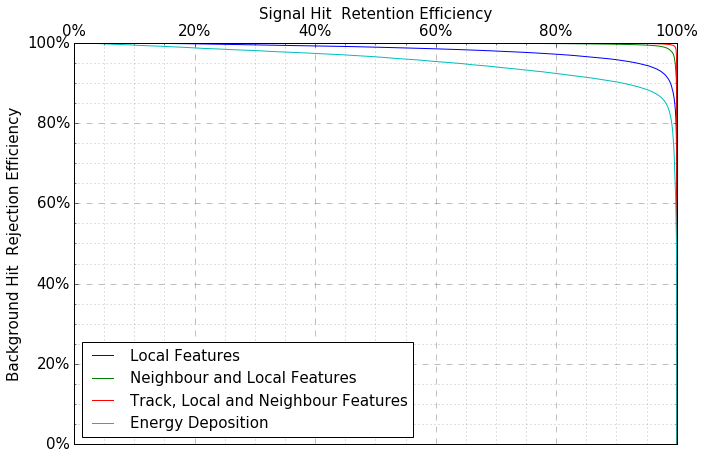

In [67]:
plot_set_font()
fig_scale = 1.8
figsize(6*fig_scale, 4*fig_scale)

plot_rocs(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics, 
         names=None,
         zoom=False,
         datum_label="Hit")
plt.show()

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


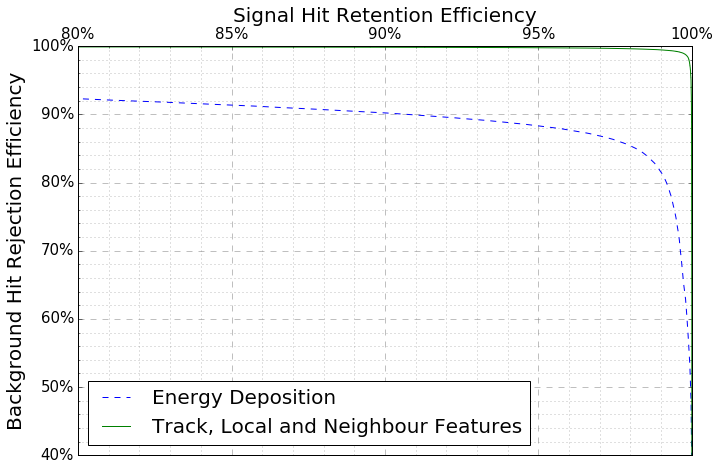

In [68]:
plot_set_font()
figsize(11, 7.3333)

plot_roc_curve(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
               final_diagnostics["Energy Deposition"][:,1], 
         zoom=True,
         zoom_x_lims=[80,100],
         zoom_y_lims=[40,100],
         label="Energy Deposition",
         datum_label="Hit",
         ls="--",
         fontsize=20)
plot_roc_curve(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
               final_diagnostics["Track, Local and Neighbour Features"][:,1], 
         zoom=True,
         zoom_x_lims=[80,100],
         zoom_y_lims=[40,100],
         label="Track, Local and Neighbour Features",
         datum_label="Hit",
         fontsize=20)
plt.show()

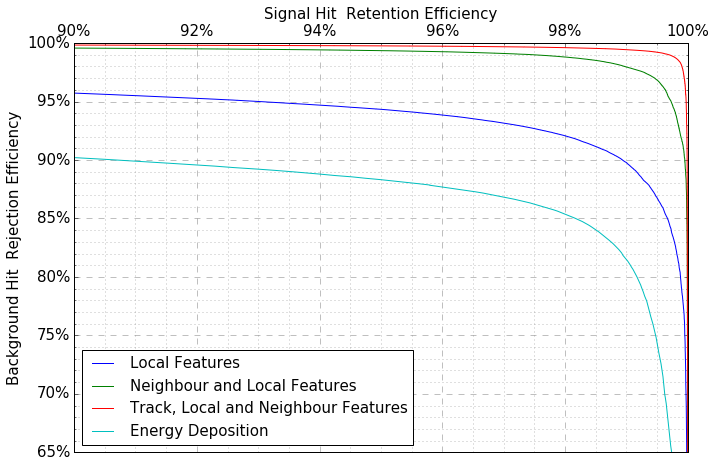

In [69]:
plot_set_font()
plot_rocs(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics, 
         zoom=True,
         zoom_x_lims=[90,100],
         zoom_y_lims=[65,100],
         datum_label="Hit")
plt.show()

In [70]:
figsize(10, 5)

Sig Occ: 82.30832510694307 , Back Occ : 612.7051661730833
All Occ: 695.0134912800263, 0.15506771336011296
NumHits: 695.0134912800263
MinMultiHit: 0.0


/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


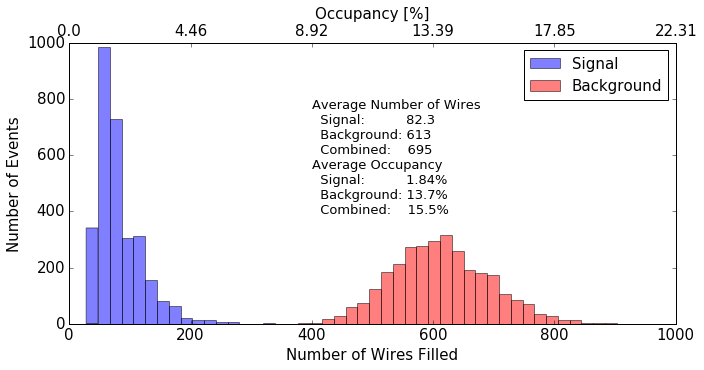

In [71]:
sig_occupy, back_occupy, occupy = test_s.cdc.get_occupancy()
plot_occupancies(sig_occupy, back_occupy, occupy, x_pos=0.4, y_pos=0.8)

In [72]:
sig_occ, back_occ, occ = list(), list(), list()
for event in range(test_s.cdc.n_events):
    #sig_occ += [sum(test_s.cdc.get_signal_hits(event)[trk_scr_name])]
    #back_occ += [sum(test_s.cdc.get_background_hits(event)[trk_scr_name])]
    #occ += [sum(test_s.cdc.get_events(event)[trk_scr_name])]
    sig_hits = test_s.cdc.get_signal_hits(event)
    sig_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=sig_hits,
                                    greater_than=0.624549)
    sig_occ += [len(np.unique(sig_hits[test_s.cdc.flat_name]))]
    bkg_hits = test_s.cdc.get_background_hits(event)
    bkg_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=bkg_hits,
                                    greater_than=0.624549)
    back_occ += [len(np.unique(bkg_hits[test_s.cdc.flat_name]))]
    all_evt_hits = test_s.cdc.get_events(event)
    all_evt_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=all_evt_hits,
                                    greater_than=0.624549)
    occ += [len(np.unique(all_evt_hits[test_s.cdc.flat_name]))]  

# print some infor
avg_n_hits = np.average(test_s.cdc.event_to_n_hits)
avg_occ = np.average(occ)
print("Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ)))
print("All Occ: {}, {}".format(avg_occ, avg_occ/4482.))
print("NumHits: {}".format(avg_n_hits))
print("MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ)))

Sig Occ: 80.62915432708128 , Back Occ : 2.3649226719315566
All Occ: 82.99407699901283, 0.018517197010043025
NumHits: 695.0134912800263
MinChansMultiHit: 7.374254120427089


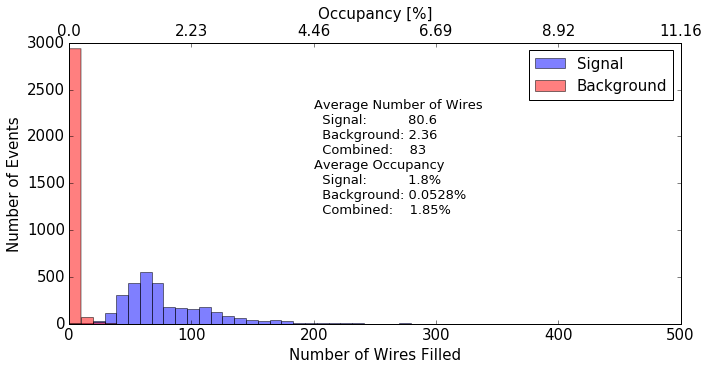

In [73]:
plot_set_font()
plot_occupancies(sig_occ, back_occ, occ, x_pos=0.4, y_pos=0.8)

In [74]:
labels = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, 
                                  flatten=True)

In [75]:
%run visualizations.ipynb

Populating the interactive namespace from numpy and matplotlib


/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Background acceptance 0.200589040559
Signal acceptance 0.991760449357


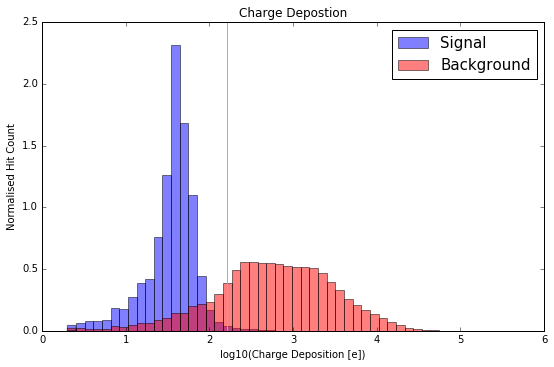

In [77]:
fig_scale = 1.3
figsize(6*fig_scale, 4*fig_scale)

plot_old_classifier_line = True
plot_feature( np.log10(test_s.cdc.get_signal_hits()[test_s.cdc.edep_name] + 1), 
              np.log10(test_s.cdc.get_background_hits()[test_s.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)

if plot_old_classifier_line:
    edep_val = 163
    bkg_edeps = test_s.cdc.get_background_hits()[test_s.cdc.edep_name]
    sig_edps = test_s.cdc.get_signal_hits()[test_s.cdc.edep_name]
    print("Background acceptance",sum(bkg_edeps < 163)/float(bkg_edeps.shape[0]))
    print("Signal acceptance",sum(sig_edps < 163)/float(sig_edps.shape[0]))
    plt.axvline(x=np.log10(edep_val+1), c="Orange")

show()

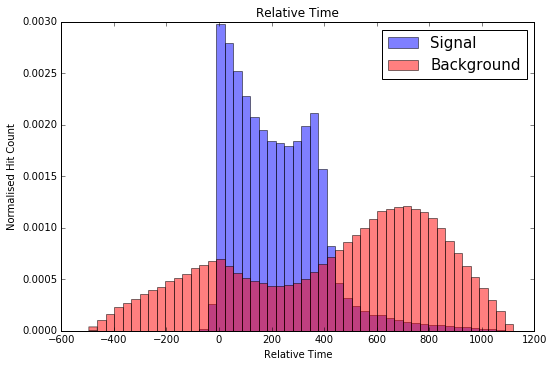

In [78]:
plot_feature( test_s.cdc.get_signal_hits()[rel_time_name],
              test_s.cdc.get_background_hits()[rel_time_name],
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

In [79]:
cdc_radii = np.array([53.0, 54.6, 56.2, 57.8, 59.4, 61.0, 62.6, 64.2, 65.8,
                      67.4, 69.0, 70.6, 72.2, 73.8, 75.4, 77.0, 78.6, 80.2])

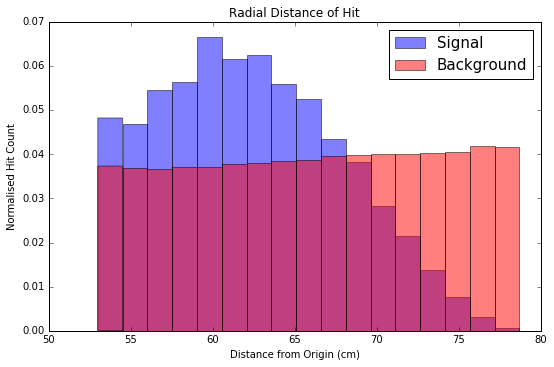

In [80]:
plot_feature( cdc_radii[test_s.cdc.get_signal_hits()[row_name].astype(int)], 
              cdc_radii[test_s.cdc.get_background_hits()[row_name].astype(int)], 
              xlabel="Distance from Origin (cm)", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Radial Distance of Hit", 
              nbins=18)
show()

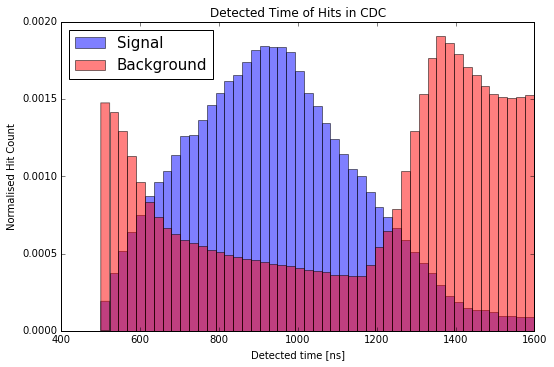

In [81]:
plot_feature( test_s.cdc.get_signal_hits()[test_s.cdc.time_name],
              test_s.cdc.get_background_hits()[test_s.cdc.time_name],
              xlabel="Detected time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

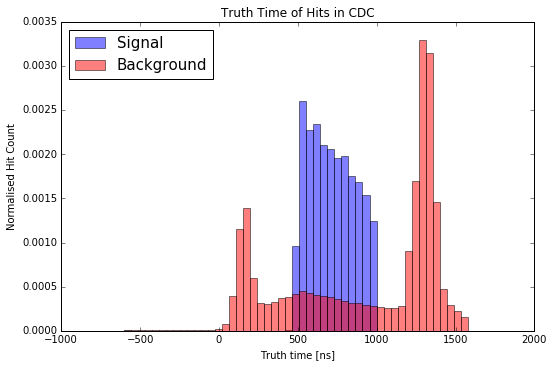

In [82]:
plot_feature( test_s.cdc.get_signal_hits()[test_s.cdc.time_name] -\
              test_s.cdc.get_signal_hits()[drift_name],  
              test_s.cdc.get_background_hits()[test_s.cdc.time_name] -\
              test_s.cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

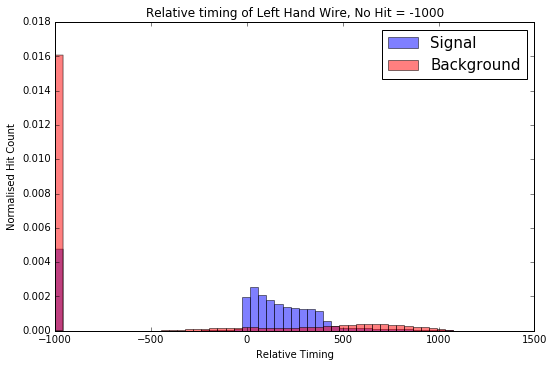

In [83]:
plot_feature(  test_s.cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 1], 
               test_s.cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 0], 
              xlabel="Relative Timing", ylabel="Normalised Hit Count", 
              title="Relative timing of Left Hand Wire, No Hit = -1000",
              xlog=False, nbins=bins_for_plots)
show()

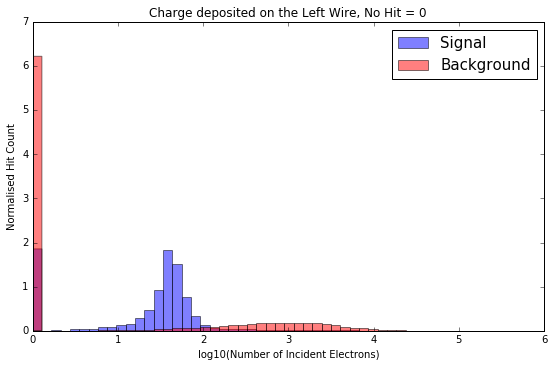

In [84]:
plot_feature(  np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 1]), 
               np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 0]), 
              xlabel="log10(Number of Incident Electrons)", 
              ylabel="Normalised Hit Count", xlog=False,
              title="Charge deposited on the Left Wire, No Hit = 0", 
              nbins=bins_for_plots)
show()

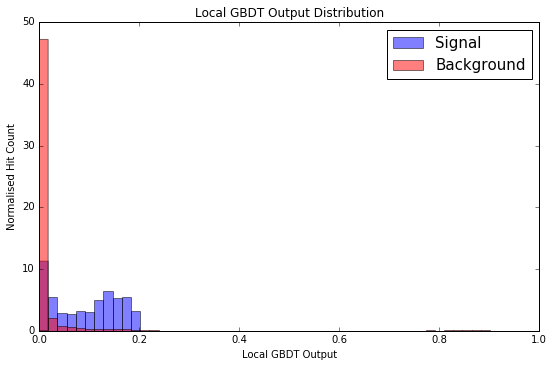

In [85]:
plot_feature( test_s.cdc.get_signal_hits()[lcl_scr_name], 
              test_s.cdc.get_background_hits()[lcl_scr_name],  
              xlabel="Local GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Local GBDT Output Distribution", nbins=bins_for_plots)
show()

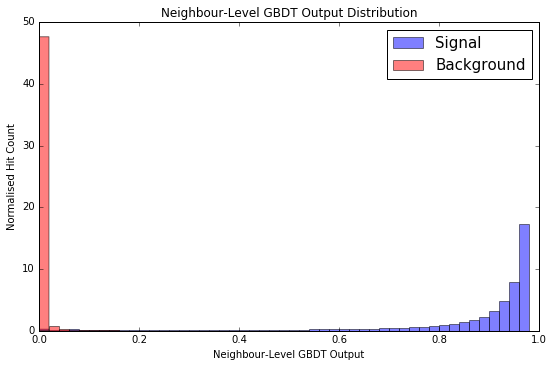

In [86]:
plot_feature( test_s.cdc.get_signal_hits()[ngh_scr_name], 
              test_s.cdc.get_background_hits()[ngh_scr_name], 
              xlabel="Neighbour-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Neighbour-Level GBDT Output Distribution", nbins=bins_for_plots)
show()

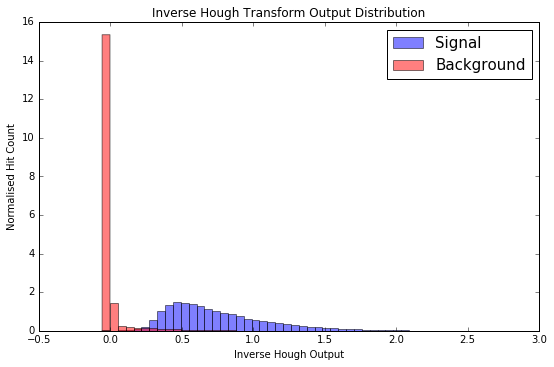

In [87]:
plot_feature( test_s.cdc.get_signal_hits()[hgh_scr_name], 
              test_s.cdc.get_background_hits()[hgh_scr_name], 
              xlabel="Inverse Hough Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Inverse Hough Transform Output Distribution", 
              nbins=bins_for_plots)
show()

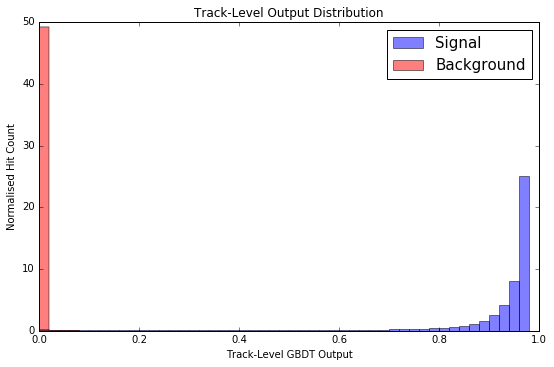

In [88]:
plot_feature( test_s.cdc.get_signal_hits()[trk_scr_name], 
              test_s.cdc.get_background_hits()[trk_scr_name],  
              xlabel="Track-Level GBDT Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Track-Level Output Distribution", 
              nbins=bins_for_plots)
show()

In [89]:
from collections import OrderedDict
feat_label_dict = OrderedDict([
            (rel_time_name,               "Timing"),  
            (rel_time_name     +"_left",  "Left Timing"),  
            (rel_time_name     +"_right", "Right Timing"),  
            (test_s.cdc.edep_name,          "Charge"),  
            (test_s.cdc.edep_name+"_left",  "Left Charge"),  
            (test_s.cdc.edep_name+"_right", "Right Charge"),  
            (row_name,           "R Distance"),  
            (hgh_scr_name,               r"Hough, $W_j'$")
    ])

In [90]:
np.arange(-1, 1, 0.25)

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75])

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


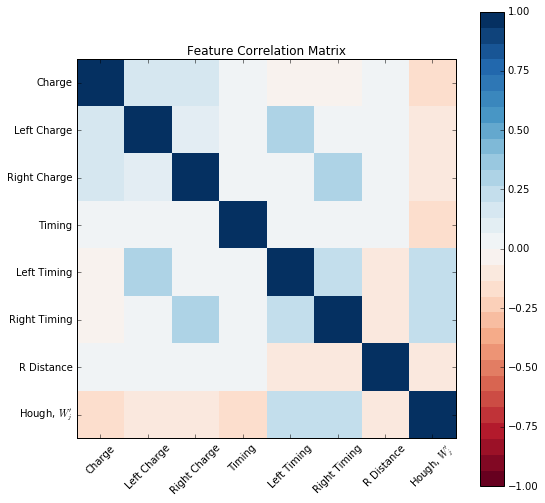

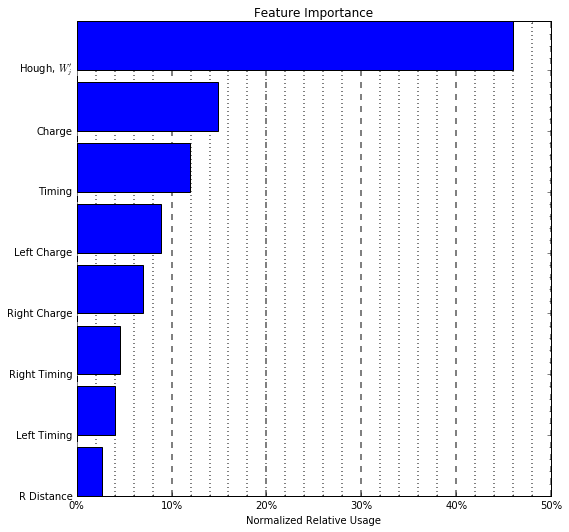

In [91]:
figsize(8.5,8.5) 
plot_feature_correlations(test_data, "Feature Correlation Matrix", feat_label_dict)
show()
plot_feature_importance(hough_gbdt, feat_label_dict)
show()

## Visualiaze the Data

In [92]:
high_hit = np.arange(test_s.cdc.n_events)[test_s.cdc.event_to_n_hits >= 600]
#high_hit = np.where(test_s.cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(test_s.cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[np.logical_and(n_sig > 70, n_sig < 80)]
print(len(good_event))
print(good_event)

304
[  29   31   33   43   44   45   61   78   93   94   98  116  118  123  131
  153  156  160  170  180  200  202  210  213  218  234  246  249  251  253
  256  268  274  279  282  285  286  299  322  338  339  342  343  353  354
  368  374  384  385  389  398  400  409  410  421  438  444  454  455  456
  470  472  474  492  500  503  505  525  532  550  553  554  587  589  609
  624  629  656  669  672  676  681  684  703  709  721  733  771  776  780
  794  799  814  817  819  842  848  853  866  869  872  881  922  944  961
  970  977  978 1016 1046 1069 1070 1090 1101 1103 1104 1137 1144 1145 1171
 1175 1179 1181 1185 1187 1233 1235 1248 1254 1287 1298 1299 1319 1328 1332
 1356 1403 1405 1420 1429 1441 1449 1455 1458 1461 1474 1475 1485 1503 1508
 1517 1541 1554 1559 1570 1579 1582 1584 1607 1609 1615 1626 1628 1642 1648
 1663 1670 1685 1686 1687 1700 1709 1731 1732 1735 1744 1751 1764 1787 1795
 1803 1816 1829 1835 1842 1849 1866 1868 1905 1914 1916 1931 1932 1933 1947
 1948 19

In [142]:
# Event information\
#event = 17, good, big island of hits
#event = 18, very good
event = 18
event = good_event[event]
event = int(event)
#event = evt_samp[3][event]
add_trans = True
save = False
savedir = "~/development/ICEDUST/track-finding-yandex/images/CTD_2018/"

print(np.unique(test_s.cdc.get_measurement("CDCHit.fEventNumber", events=[event])).astype(int))

to_plot = np.take([0,2,1], test_s.cdc.get_measurement("CDCHit.fIsSig", 
                                   events=event, 
                                   default=-1, 
                                   only_hits=False,
                                   flatten=True).astype(int) + 1)
ngh_pred_size = plot_norm_size(test_s.cdc.get_measurement(ngh_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
trk_pred_size = plot_norm_size(test_s.cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
hough_output = test_s.cdc.get_measurement(hgh_scr_name, 
                                        events=event, 
                                        default=0, 
                                        only_hits=False,
                                        flatten=True)

#hough_event = evt_samp[3][event]
hough_event = event

plot_hough_image_3 = hough_images[hough_event,:hough.track.n_points] +\
                     hough_images[hough_event,hough.track.n_points:] 
plot_hough_no_rw = hough_transformer.normed_corresp.T.dot(ngh_pred_size.T).T
plot_hough_no_rw = plot_hough_no_rw[:hough.track.n_points] + plot_hough_no_rw[hough.track.n_points:]

[   3210 9115426]


611.0


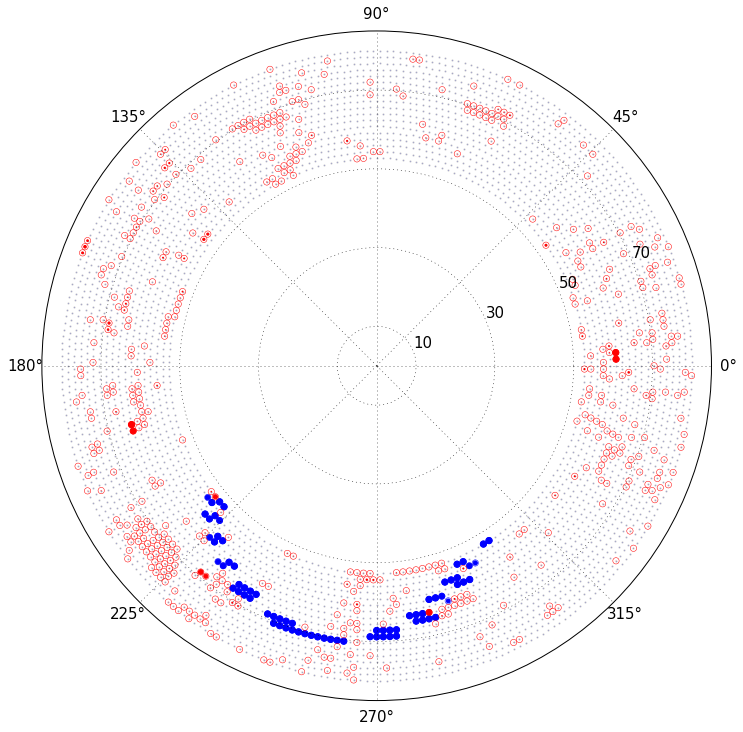

In [143]:
# First GBDT output
print(occupy[event])
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

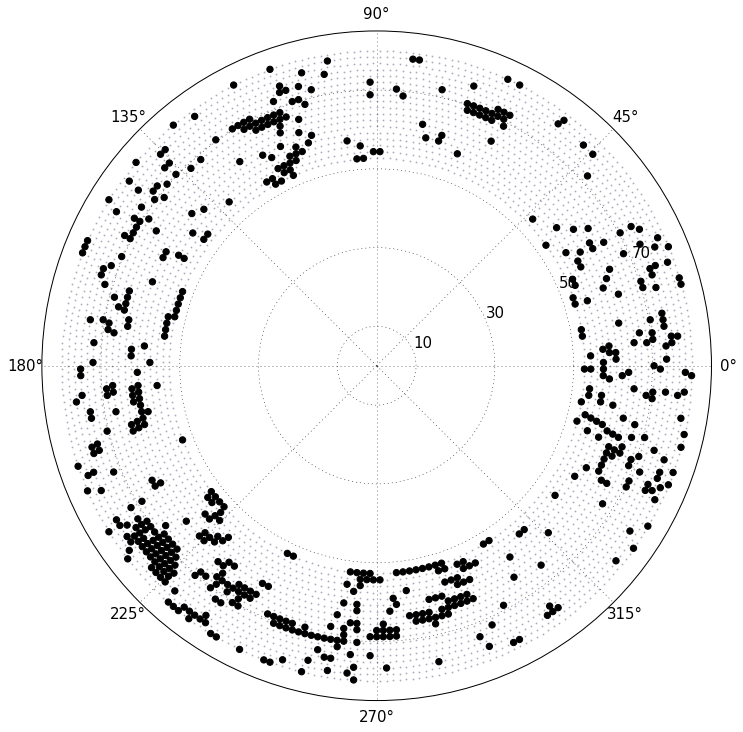

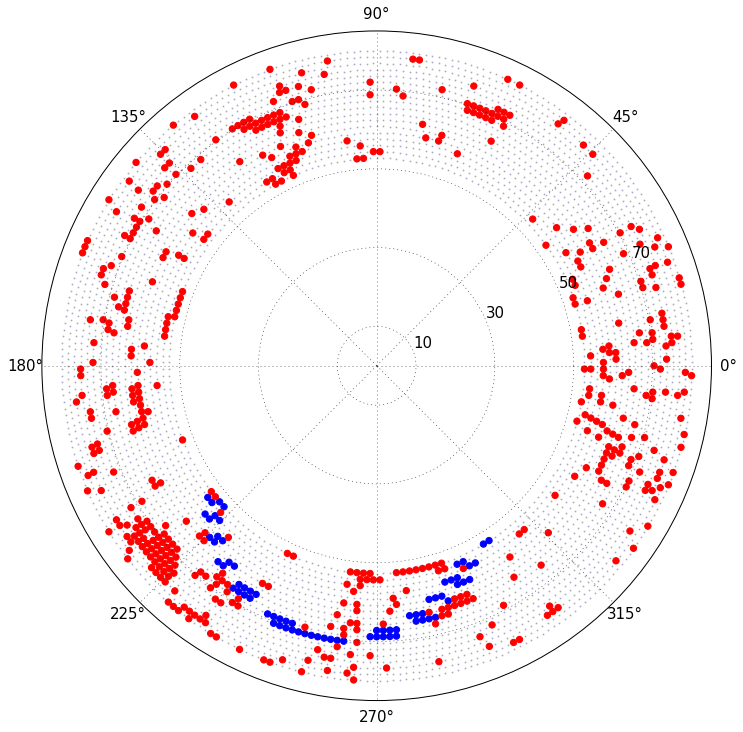

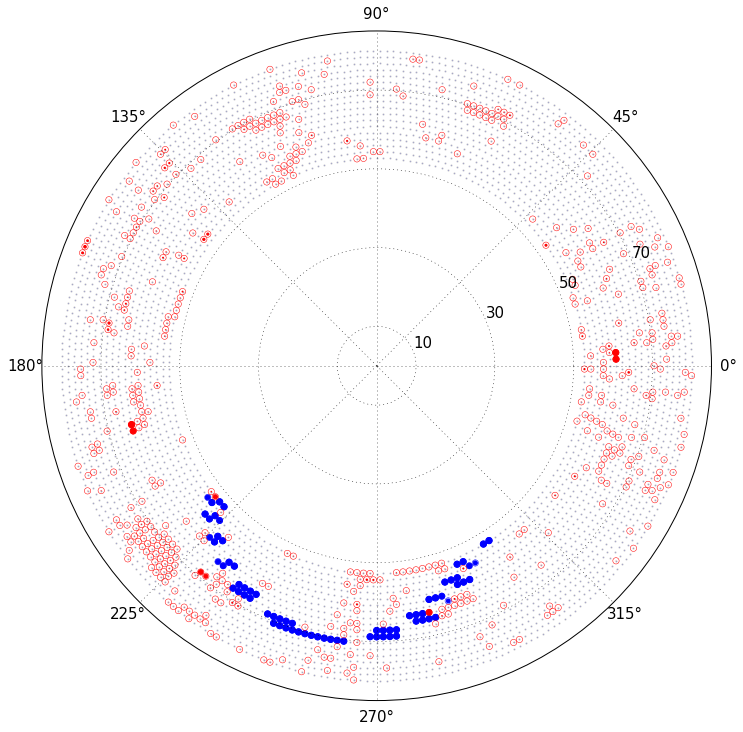

34 34.5 31.5
Length of draw tracks are 1598


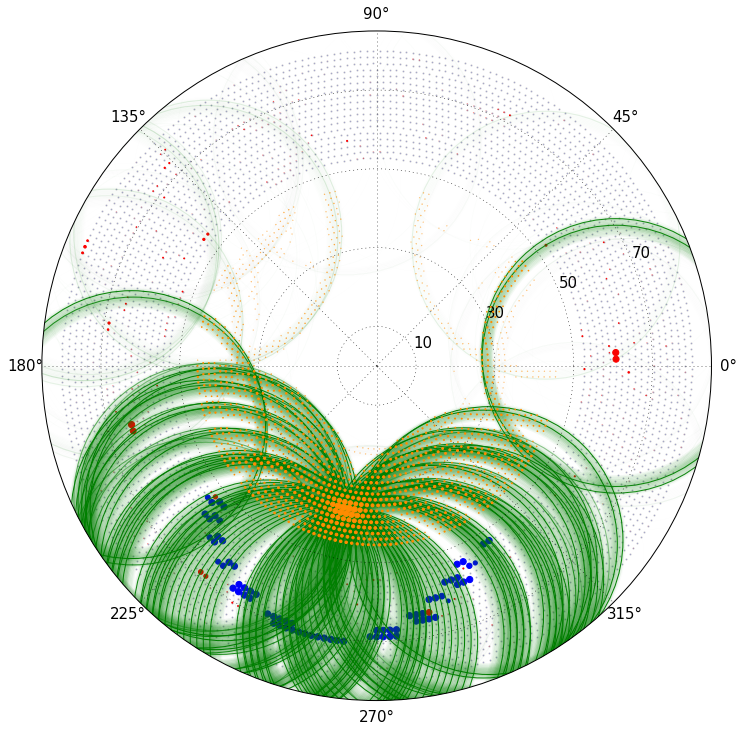

Length of draw tracks are 80
34 34.5 31.5


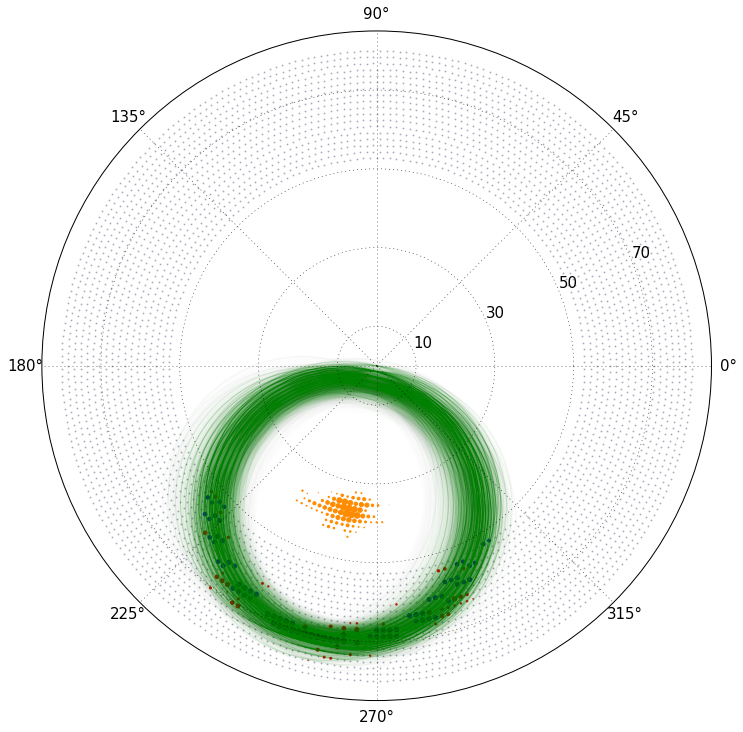

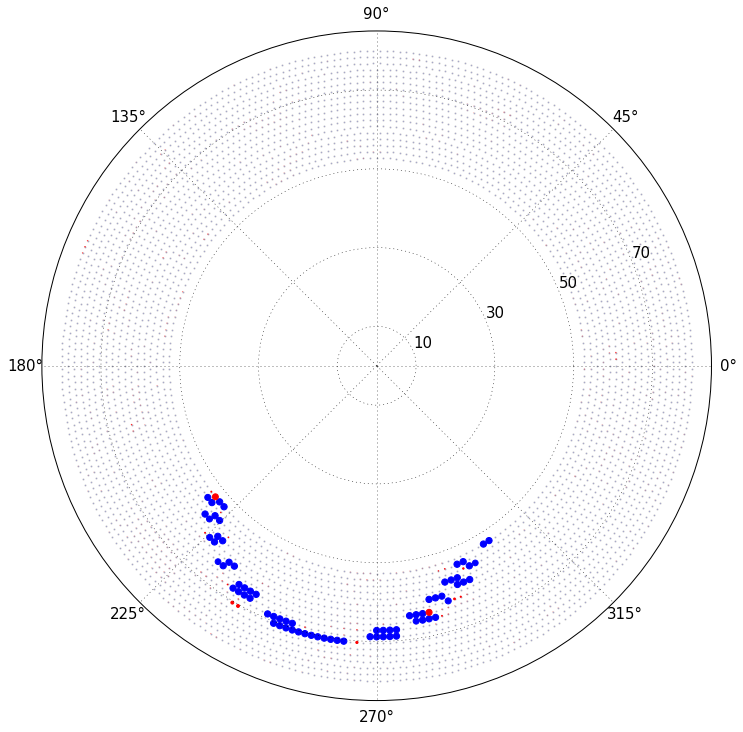

In [148]:
# Basic output
plot_output(to_plot, test_s.cdc.geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size, 
            add_transform=add_trans,
            hough=hough)
plot_add_tracks(test_s.cdc.geom, hough, 
                size=plot_norm_size(plot_hough_no_rw - np.amin(plot_hough_no_rw),40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, test_s.cdc.geom, 
            size=plot_norm_size(hough_output))
plot_add_tracks(test_s.cdc.geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40), 
                add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Final
plot_output(to_plot, test_s.cdc.geom, size=plot_norm_size(trk_pred_size))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

In [150]:
from tabulate import tabulate

In [151]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print(tabulate(table, headers="firstrow"))

In [152]:
fpr, tpr, thresh = roc_curve(test_s.cdc.data["CDCHit.fIsSig"], 
          test_s.cdc.data[trk_scr_name])

print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=1)

  Bkg Retained    Sig Retained    Threshold
--------------  --------------  -----------
          0.01        0.996922  0.0766862
          0.02        0.999029  0.0134202
          0.03        0.999408  0.00576891
          0.04        0.999604  0.00324705
          0.05        0.999728  0.00210597
          0.06        0.999764  0.00151691
          0.07        0.999804  0.00114092
          0.08        0.999844  0.000878582
          0.09        0.999868  0.000717771
          0.1         0.99988   0.000613055
          0.11        0.999888  0.000524948
          0.12        0.999892  0.000458238
          0.13        0.9999    0.000408706
          0.14        0.999904  0.000366479
          0.15        0.999908  0.00032418
          0.16        0.999908  0.000290926
          0.17        0.999912  0.000265522
          0.18        0.999912  0.000240592
          0.19        0.99992   0.00022041
          0.2         0.999924  0.000202706
  Bkg Retained    Sig Retained    Threshold

In [153]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=9000, threshold_max=10000, bins=10000, steps=1)

  Bkg Retained    Sig Retained    Threshold
--------------  --------------  -----------
        0.0001        0.123905  0.996184
        0.0002        0.251736  0.99463
        0.0003        0.355524  0.992644
        0.0004        0.432167  0.990234
        0.0005        0.497691  0.988372
        0.0006        0.556791  0.986274
        0.0007        0.619122  0.983824
        0.0008        0.673724  0.981216
        0.0009        0.722234  0.97798
        0.001         0.757723  0.974697
        0.0011        0.787631  0.971145
        0.0012        0.813285  0.967302
        0.0013        0.83734   0.962418
        0.0014        0.85635   0.957365
        0.0015        0.875011  0.95087
        0.0016        0.889736  0.943721
        0.0017        0.901649  0.936734
        0.0018        0.911712  0.929138
        0.0019        0.921366  0.920907
        0.002         0.929542  0.912322
        0.0021        0.936674  0.902044
        0.0022        0.942215  0.891624
        0.002

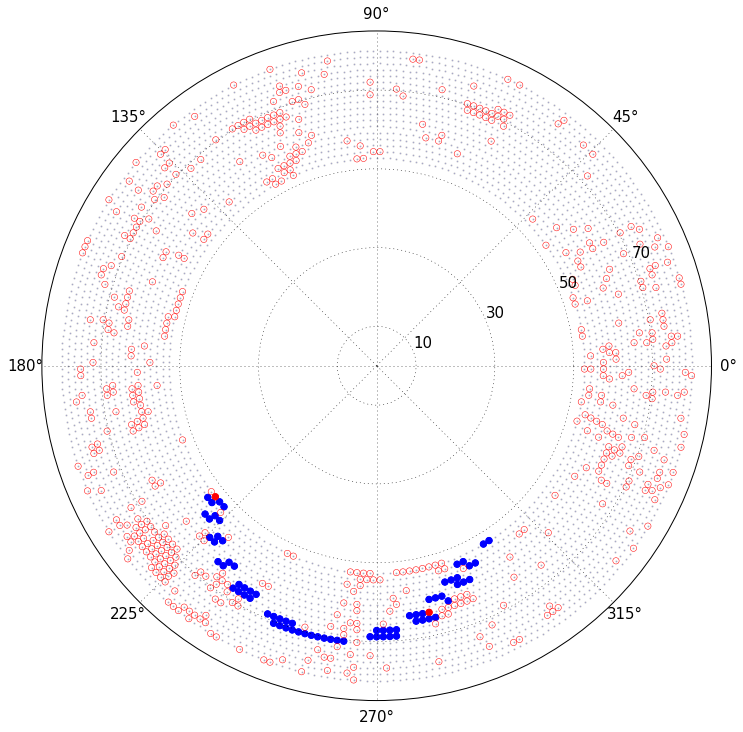

In [154]:
# Final
plot_output(to_plot, test_s.cdc.geom, size=plot_norm_size(test_s.cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True) > 0.298557))
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

## Export the Data

In [161]:
# TODO Get working

In [155]:
export_name = "track_finding_sample_scored_MC4p_0.root"

In [156]:
# Task 1 : Print signal only
# Task 2 : Print signal + background

In [ ]:
test_s.cdc.trim_hits(test_s.cdc.hits_index_name, 
                   values=test_s.cdc.data[hit_masks[3]][test_s.cdc.hits_index_name])

In [160]:
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from rootpy.vector import LorentzVector
from rootpy import stl
from random import gauss, randint

# Map from python types to c++ types
type_dict_no_array = {dtype('float64'):"float", 
                      dtype('int32')  :"long",
                      dtype('int64')  :"long"}

type_dict_no_array = {dtype('float64'):"FloatCol()", 
                      dtype('int32')  :"IntCol()",
                      dtype('int64')  :"long"}

# Define the model of the output root file
class CDCTree(TreeModel):
    # Create a std::vector branch for each measurement
    for measure in test_s.cdc.data.dtype.names:
        this_dtype = type_dict[test_s.cdc.data.dtype[measure]]
        measure = measure.replace(".", "_")
        exec(measure + " = stl.vector(this_dtype)")
    # Delete branches we do not want
    del measure, this_dtype

# Open the output file
with root_open(savedir+export_name, mode='recreate') as output_file:
    # Open a new tree
    output_tree = Tree("test", model=CDCTree)
    for event in range(test_s.cdc.n_events):
        if event%100 == 0:
            print(event)
        event_hits = test_s.cdc.get_events(event)
        for measure in event_hits.dtype.names:
            this_measure = event_hits[measure]
            for hit_val in this_measure:
                output_tree[measure.replace(".","_")].push_back(hit_val)
        output_tree.fill(reset=True)
    output_tree.write()

NameError: name 'type_dict' is not defined

In [ ]:
fpr, tpr, thresh = roc_curve(test_s.cdc.data["CDCHit.fIsSig"], 
          test_s.cdc.data[trk_scr_name])

In [ ]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print(tabulate(table, headers="firstrow"))

In [ ]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=5)